In [284]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor']='w'

# HI

In [285]:
import os
from astropy.utils.data import download_file
from astropy.io import fits
from spectral_cube import SpectralCube

In [286]:
from astropy import units as u

In [287]:
if os.path.exists("GC.hi.tb.allgal.fits.gz"):
    fh = fits.open("GC.hi.tb.allgal.fits.gz")
    hi_cube = SpectralCube.read(fh, use_dask=True)
else:
    hi_cube = download_file("http://www.atnf.csiro.au/research/HI/sgps/SGPS_1/GC.hi.tb.allgal.fits.gz")

In [288]:
hi_cube

DaskSpectralCube with shape=(800, 1050, 1050) and unit=K and chunk size (200, 210, 210):
 n_x:   1050  type_x: GLON-CAR  unit_x: deg    range:     5.104167 deg:  354.905556 deg
 n_y:   1050  type_y: GLAT-CAR  unit_y: deg    range:    -5.104167 deg:    5.094444 deg
 n_s:    800  type_s: VOPT      unit_s: m / s  range:  -309144.300 m / s:  349534.122 m / s

hi_cube = hi_cube.with_spectral_unit(u.km/u.s, velocity_convention='radio')

In [289]:
lv_hi_mx = hi_cube.max(axis=1)

In [290]:
from astropy.visualization import simple_norm

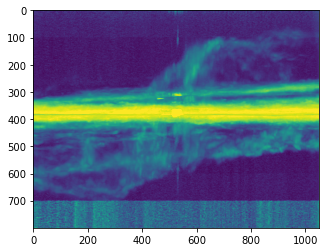

In [291]:
pl.imshow(lv_hi_mx.value, norm=simple_norm(lv_hi_mx.value, stretch='asinh', max_percent=99., min_percent=0.1))

# CO

In [292]:
if os.path.exists('GalacticCenterMosaic_downsampled4x_2kms.fits'):
    co_cube = SpectralCube.read('GalacticCenterMosaic_downsampled4x_2kms.fits', use_dask=True)
else:
    #https://sedigism.mpifr-bonn.mpg.de/SEDIGISM_DATACUBES_DR1c/G000_13CO21_Tmb_DR1.fits
    raise NotImplementedError

In [293]:
lv_co_mx = co_cube.max(axis=1)

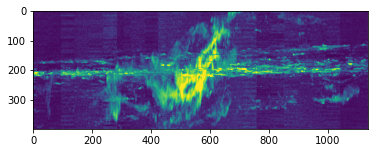

In [294]:
pl.imshow(lv_co_mx.value, norm=simple_norm(lv_co_mx.value, stretch='asinh', max_percent=99.5, min_percent=0.1))

# HNCO

In [295]:
if os.path.exists("CMZ_3mm_HNCO.fits"):
    hnco_cube = SpectralCube.read("CMZ_3mm_HNCO.fits", use_dask=True)
else:
    raise NotImplementedError

In [296]:
lv_hnco_mx = hnco_cube.max(axis=1)

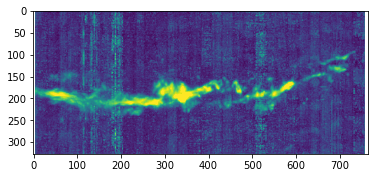

In [297]:
pl.imshow(lv_hnco_mx.value, norm=simple_norm(lv_hnco_mx.value, stretch='asinh', max_percent=99.5, min_percent=0.1))

# Dame CO

In [298]:
if os.path.exists("DHT02_Center_interp.fits"):
    cube_12co = SpectralCube.read('DHT02_Center_interp.fits', use_dask=True)
else:
    pass
    # https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/7RMW6Q/CA0UPU

In [299]:
cube_12co

DaskSpectralCube with shape=(492, 41, 201) and unit=K and chunk size (492, 41, 201):
 n_x:    201  type_x: GLON-CAR  unit_x: deg    range:    13.000000 deg:  348.000000 deg
 n_y:     41  type_y: GLAT-CAR  unit_y: deg    range:    -2.500000 deg:    2.500000 deg
 n_s:    492  type_s: VOPT      unit_s: m / s  range:     -319.239 m / s:     319.239 m / s

In [300]:
lv_dameco_mx = cube_12co.max(axis=1)

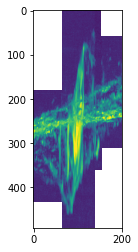

In [301]:
pl.imshow(lv_dameco_mx.value, norm=simple_norm(lv_dameco_mx.value, stretch='asinh', max_percent=99.5, min_percent=0.1))

# Projected

easy version, not allowed:

```
co_rep = lv_co_mx.reproject(lv_hi_mx.header)
co_rep
```

In [302]:
import reproject
import reproject.interpolation.core
from astropy.wcs import WCS
from scipy.ndimage import map_coordinates
from reproject.interpolation.core import efficient_pixel_to_pixel_with_roundtrip

In [303]:
# hack to get CO onto HI grid
array = lv_co_mx.value
wcs_in = lv_co_mx.wcs
wcs_in.wcs.crval[0] = 0 # need to wrap at 0
wcs_out = hi_cube.with_spectral_unit(u.km/u.s, velocity_convention='radio')[:,0,:].wcs # need to match velo convention
shape_out = lv_hi_mx.shape
order = 1
array_out = None

# Make sure image is floating point
array = np.asarray(array, dtype=float)
# shape_out must be exact a tuple type
shape_out = tuple(shape_out)

#_validate_array_out(array_out, array, shape_out)

pixel_out = np.meshgrid(*[np.arange(size, dtype=float) for size in shape_out],
                        indexing='ij', sparse=False, copy=False)
pixel_out = [p.ravel() for p in pixel_out]
# For each pixel in the ouput array, get the pixel value in the input WCS
pixel_in = efficient_pixel_to_pixel_with_roundtrip(wcs_out, wcs_in, *pixel_out[::-1])[::-1]
pixel_in = np.array(pixel_in)

if array_out is not None:
    array_out.shape = (array_out.size,)
else:
    array_out = np.empty(shape_out).ravel()

# Interpolate array on to the pixels coordinates in pixel_in
map_coordinates(array, pixel_in, order=order, cval=np.nan,
                mode='constant', output=array_out,).reshape(shape_out)

array_out.shape = shape_out
co_rep = array_out

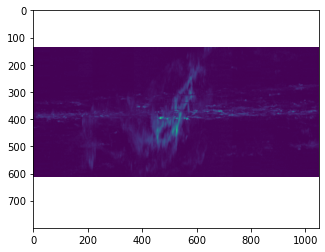

In [304]:
pl.imshow(co_rep)

In [305]:
# hack to get hnCO onto HI grid
array = lv_hnco_mx.value
wcs_in = lv_hnco_mx.wcs
#wcs_in.wcs.crval[0] = 0 # need to wrap at 0
wcs_out = hi_cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=hi_cube.wcs.wcs.restfrq*u.Hz)[:,0,:].wcs
shape_out = lv_hi_mx.shape
order = 1
array_out = None

# Make sure image is floating point
array = np.asarray(array, dtype=float)
# shape_out must be exact a tuple type
shape_out = tuple(shape_out)

#_validate_array_out(array_out, array, shape_out)

pixel_out = np.meshgrid(*[np.arange(size, dtype=float) for size in shape_out],
                        indexing='ij', sparse=False, copy=False)
pixel_out = [p.ravel() for p in pixel_out]
# For each pixel in the ouput array, get the pixel value in the input WCS
#pixel_in = efficient_pixel_to_pixel_with_roundtrip(wcs_out, wcs_in, *pixel_out[::-1])[::-1]
#pixel_in = np.array(pixel_in)
# for reasons unclear, this was trickier
xc,yc = wcs_out.wcs_pix2world(pixel_out[1], pixel_out[0], 0)
xp,yp = wcs_in.wcs_world2pix(xc, yc, 0)
pixel_in = [yp,xp]

if array_out is not None:
    array_out.shape = (array_out.size,)
else:
    array_out = np.empty(shape_out).ravel()

# Interpolate array on to the pixels coordinates in pixel_in
map_coordinates(array, pixel_in, order=order, cval=np.nan,
                mode='constant', output=array_out,).reshape(shape_out)

array_out.shape = shape_out
hnco_rep = array_out

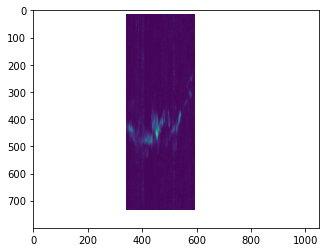

In [306]:
pl.imshow(hnco_rep)

In [307]:
# hack to get CO onto HI grid
array = lv_dameco_mx.value
wcs_in = cube_12co[:,0,:].wcs
wcs_in.wcs.cdelt[1] *= 1000
wcs_in.wcs.crval[1] *= 1000
#wcs_in.wcs.crval[0] = 0 # need to wrap at 0
wcs_out = lv_hi_mx.wcs #hi_cube.with_spectral_unit(u.km/u.s, velocity_convention='radio')[:,0,:].wcs # need to match velo convention
shape_out = lv_hi_mx.shape
order = 1
array_out = None

# Make sure image is floating point
array = np.asarray(array, dtype=float)
# shape_out must be exact a tuple type
shape_out = tuple(shape_out)

#_validate_array_out(array_out, array, shape_out)

pixel_out = np.meshgrid(*[np.arange(size, dtype=float) for size in shape_out],
                        indexing='ij', sparse=False, copy=False)
pixel_out = [p.ravel() for p in pixel_out]
# For each pixel in the ouput array, get the pixel value in the input WCS
#pixel_in = efficient_pixel_to_pixel_with_roundtrip(wcs_out, wcs_in, *pixel_out[::-1])[::-1]
#pixel_in = np.array(pixel_in)
xc,yc = wcs_out.wcs_pix2world(pixel_out[1], pixel_out[0], 0)
xp,yp = wcs_in.wcs_world2pix(xc, yc, 0)
pixel_in = [yp,xp]

if array_out is not None:
    array_out.shape = (array_out.size,)
else:
    array_out = np.empty(shape_out).ravel()

# Interpolate array on to the pixels coordinates in pixel_in
map_coordinates(array, pixel_in, order=order, cval=np.nan,
                mode='constant', output=array_out,).reshape(shape_out)

array_out.shape = shape_out
dameco_rep = array_out

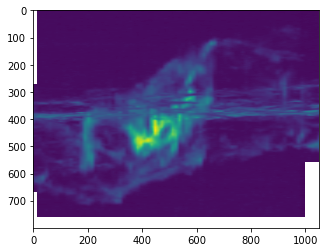

In [308]:
pl.imshow(dameco_rep)

In [309]:
norm_hi = simple_norm(lv_hi_mx, stretch='log', max_percent=99.999, min_percent=15)
norm_co = simple_norm(co_rep, stretch='asinh', max_percent=99.95, min_percent=0.1)
norm_hnco = simple_norm(hnco_rep, stretch='asinh', max_percent=99.995, min_percent=0.1)
norm_dameco = simple_norm(dameco_rep, stretch='asinh', max_percent=99.995, min_percent=0.1)
rgb = np.array([norm_hi(lv_hi_mx.value)*0.7,  norm_co(co_rep), norm_dameco(dameco_rep), ]).swapaxes(0,2).swapaxes(0,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


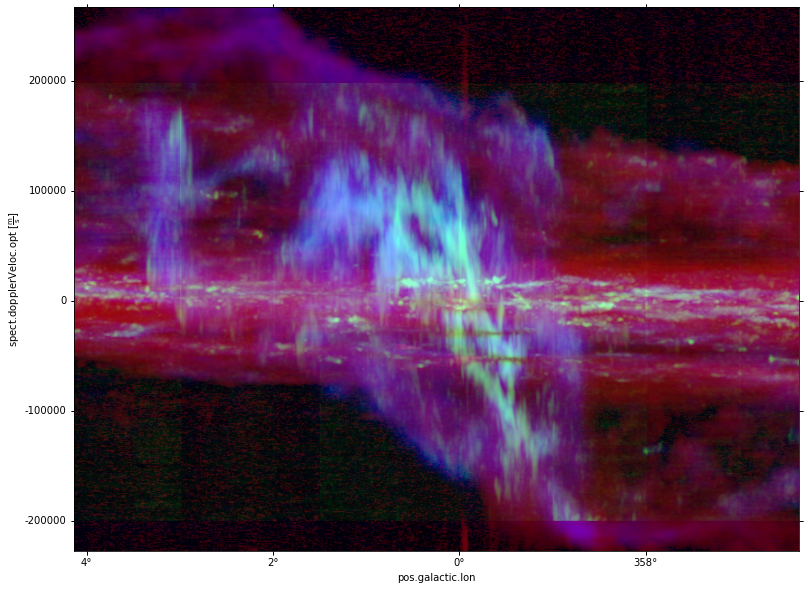

In [314]:
pl.figure(figsize=(16,10))
slc = [slice(100,700), slice(100,900)]
ax = pl.subplot(projection=lv_hi_mx.wcs[slc])
ax.imshow(rgb[slc[0],slc[1],:])